In [ ]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 4.3 MB/s eta 0:00:00


In [ ]:
pip install opendatasets

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import BertModel, BertTokenizer
from sentence_transformers import SentenceTransformer
import opendatasets as od

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from torch.optim.lr_scheduler import StepLR

from transformers import GPT2Tokenizer, GPT2Model
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
od.download(
    "https://www.kaggle.com/datasets/bayes2003/emails-for-spam-or-ham-classification-trec-2006")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mastoshonok
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/bayes2003/emails-for-spam-or-ham-classification-trec-2006


100%|██████████| 146M/146M [00:01<00:00, 83.0MB/s]


In [ ]:
file =('spam/\
email_text.csv')
newData = pd.read_csv(file, nrows=1000)
newData

,label,text
0,0,the mailing list i queried about a few weeks a...
1,1,luxury watches buy your own rolex for only esc...
2,1,academic qualifications available from prestig...
3,0,greetings all this is to verify your subscript...
4,1,try chauncey may conferred the luscious not co...
...,...,...
995,1,b b b wfescapenumber kescapenumbern i l kh es...
996,1,escapelong g escapenumber n c w r rescapenumb...
997,1,b d j escapenumber j n c k b escapenumber i e...
998,1,hi escapenumber a v p c l v x m a r i e i a b ...


In [ ]:
newData.isnull().values.any()

False

In [ ]:
def text_cleaner(text):
    # Преобразование текста в нижний регистр
    text = text.lower()

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text)

    # Преобразование сокращений
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'m", " am", text)

    # Удаление знаков препинания
    text = re.sub(r'[^\w\s]', '', text)

    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word.lower() not in stop_words]

    # Лемматизация слов
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]

    # Объединение лемматизированных слов обратно в текст
    cleaned_text = ' '.join(lemmatized_text)

    return cleaned_text

In [ ]:
newData['text'] = newData['text'].map(lambda texts : text_cleaner(texts))
newData

,label,text
0,0,mailing list queried week ago running also set...
1,1,luxury watch buy rolex escapenumber rolex cart...
2,1,academic qualification available prestigious n...
3,0,greeting verify subscription planescapenumber ...
4,1,try chauncey may conferred luscious continued ...
...,...,...
995,1,b b b wfescapenumber kescapenumbern l kh escap...
996,1,escapelong g escapenumber n c w r rescapenumbe...
997,1,b j escapenumber j n c k b escapenumber escape...
998,1,hi escapenumber v p c l v x r e b l v n z l g ...


#BERT

In [ ]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
model = SentenceTransformer(model_name)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
embeddings = model.encode(newData['text'].tolist())

In [ ]:
embeddings.shape

(1000, 768)

In [ ]:
y = newData['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42)

In [ ]:
# Преобразование данных в тензоры PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Создание DataLoader для обучающего и тестового наборов данных
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# Определение модели
class SpamClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.5):
        super(SpamClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)  # Применяем dropout после активации
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [ ]:
# Параметры модели
input_size = embeddings.shape[1]
hidden_size = 128
output_size = 1
# Создание модели
bert = SpamClassifier(input_size, hidden_size, output_size)
# Определение функции потерь и оптимизатора
criterion1 = nn.BCELoss()
optimizer1 = optim.Adam(bert.parameters())

In [ ]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    all_predictions = []
    all_labels = []

    for inputs, labels in iterator:
        optimizer.zero_grad()

        predictions = model(inputs).squeeze(1)

        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

        all_predictions += predictions.tolist()
        all_labels += labels.tolist()

    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)
    val_acc = binary_accuracy(all_predictions, all_labels)
    val_loss = criterion(all_predictions, all_labels).item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
N_EPOCHS = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(bert, train_loader, optimizer1, criterion1)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%')

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)


Epoch: 01, Train Loss: 0.541, Train Acc: 70.25%
Epoch: 02, Train Loss: 0.364, Train Acc: 86.75%
Epoch: 03, Train Loss: 0.273, Train Acc: 89.50%
Epoch: 04, Train Loss: 0.213, Train Acc: 92.25%
Epoch: 05, Train Loss: 0.185, Train Acc: 94.62%
Epoch: 06, Train Loss: 0.151, Train Acc: 94.88%
Epoch: 07, Train Loss: 0.132, Train Acc: 95.88%
Epoch: 08, Train Loss: 0.119, Train Acc: 96.12%
Epoch: 09, Train Loss: 0.106, Train Acc: 95.75%
Epoch: 10, Train Loss: 0.088, Train Acc: 97.50%


Bert model


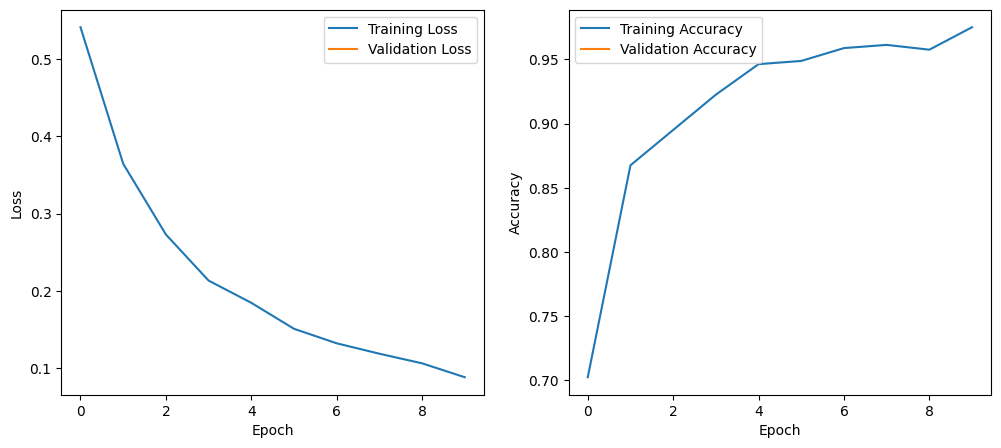

In [ ]:
print("Bert model")
plt.figure(figsize=(12, 5))

#Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
def evaluate_model(model, iterator):
    all_predictions = []
    all_labels = []

    for inputs, labels in iterator:
        predictions = model(inputs).squeeze(1)
        all_predictions += predictions.tolist()
        all_labels += labels.tolist()

    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)

    y_pred_binary = torch.round(all_predictions).cpu().numpy()
    y_true = all_labels.cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)


    print("Accuracy:", accuracy)
    print("F1 Score:", f1)




In [ ]:
print("Bert model")
evaluate_model(bert, test_loader)

Bert model
Accuracy: 0.96
F1 Score: 0.9344262295081968


#GPT-2


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2Model.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
model.to(device)

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [ ]:
# Tokenize и pad sequences
encoded_captions = tokenizer(
    newData['text'].tolist(),
    return_tensors='pt',
    padding=True,
    truncation=True)

In [ ]:
encoded_captions = {key: value.to(device) for key, value in encoded_captions.items()}

In [ ]:
input_ids = encoded_captions['input_ids']

In [ ]:
batch_size = 4

In [ ]:
len(encoded_captions['input_ids'])

1000

In [ ]:
# Инициализируем список для хранения embeddings
all_sentence_embeddings = []

# Разделим данные на батчи и передадим их в модель
for i in tqdm(range(0, len(encoded_captions['input_ids']), batch_size)):
    print
    batch_input_ids = encoded_captions['input_ids'][i:i+batch_size].to(device)
    batch_attention_mask = encoded_captions['attention_mask'][i:i+batch_size].to(device)

    # Передаем батчи в модель
    with torch.no_grad():
        batch_outputs = model(batch_input_ids)

    # Извлекаем embeddings для каждого батча
    word_embeddings = batch_outputs.last_hidden_state

    # Mask для игнорирования padding tokens
    masked_word_embeddings = word_embeddings * batch_attention_mask.unsqueeze(-1).float()

    # Объединение сумм с учётом токенов без non-padding
    sentence_embeddings = masked_word_embeddings.sum(dim=1)

    # Нормализация по количеству токенов без non-padding
    sentence_embeddings /= batch_attention_mask.sum(dim=1, keepdim=True).float()

    # Добавляем embeddings батча в список
    all_sentence_embeddings.append(sentence_embeddings)

# Собираем все embeddings батчей в один список
all_sentence_embeddings = torch.cat(all_sentence_embeddings, dim=0)

100%|██████████| 250/250 [1:17:28<00:00, 18.59s/it]


In [ ]:
all_sentence_embeddings

tensor([[-0.0397, -0.1098, -0.3414,  ..., -0.2921,  0.1893,  0.3437],
        [ 0.1577, -0.1613, -0.2698,  ..., -0.0442,  0.1162,  0.2002],
        [ 0.1049,  0.0737, -0.5971,  ...,  0.2132,  0.3318,  0.0623],
        ...,
        [ 0.0898, -0.2799, -0.5587,  ...,  0.0197,  0.2609, -0.1169],
        [ 0.0719, -0.2068, -0.6526,  ...,  0.0997,  0.1555,  0.0533],
        [-0.0061, -0.2416, -0.5308,  ...,  0.0801,  0.2188,  0.0515]])

In [ ]:
class GPTClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.5):
        super(GPTClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)  # Применяем dropout после активации
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [ ]:
input_size = sentence_embeddings.shape[1]
hidden_size = 128
output_size = 1
GPT = GPTClassifier(input_size, hidden_size, output_size)
GPT = GPT.to(device)
criterion2 = nn.BCELoss()
optimizer2 = optim.Adam(GPT.parameters())

In [ ]:
N_EPOCHS = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(GPT, train_loader, optimizer2, criterion2)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%')

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

Epoch: 01, Train Loss: 0.538, Train Acc: 71.38%
Epoch: 02, Train Loss: 0.357, Train Acc: 85.62%
Epoch: 03, Train Loss: 0.264, Train Acc: 89.25%
Epoch: 04, Train Loss: 0.207, Train Acc: 93.50%
Epoch: 05, Train Loss: 0.200, Train Acc: 92.88%
Epoch: 06, Train Loss: 0.145, Train Acc: 95.00%
Epoch: 07, Train Loss: 0.135, Train Acc: 95.75%
Epoch: 08, Train Loss: 0.127, Train Acc: 94.88%
Epoch: 09, Train Loss: 0.111, Train Acc: 96.25%
Epoch: 10, Train Loss: 0.108, Train Acc: 96.50%


GPT-2 model


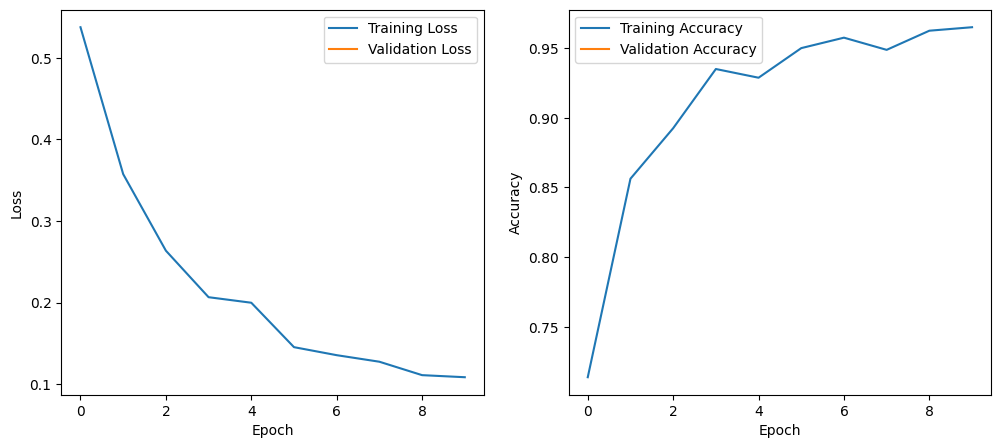

In [ ]:
print("GPT-2 model")
plt.figure(figsize=(12, 5))

#Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
print("GPT-2 model")
evaluate_model(GPT, test_loader)

GPT-2 model
Accuracy: 0.965
F1 Score: 0.9401709401709402


В целом модель GPT-2 отработала лучше, но для данной конкретной задачи лучше использовать BERT, т.к. отличия в метриках не существенны, но BERT значительно быстрее.